# Vivarium overview

**Overview:**  This tutorial shows...


In [1]:
# import the vivarium Process and Composite base classes
from vivarium.core.process import (
    Process, 
    Composite,
)

# helper functions for composition
from vivarium.core.composition import (
    simulate_process_in_experiment,
    simulate_compartment_in_experiment,
    compartment_in_experiment,
    compose_experiment,
    GENERATORS_KEY,
)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# vivarium plotting functions
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_compartment_topology

# other imports
import pylab as plt
import numpy as np

# suppress warnings
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [26]:
def Gillespie(X, dT, t0, ktx, kdeg):
    #X: initial condition
    #dT: how long to simulate
    #ktx: transcription rate
    #kdeg: degradation rate
    stoichiometry = np.array([[0, 1], [0, -1]])
    
    t = t0 #Current time
    while t < t0 + dT:
        #Calculate propensities
        propensities = [ktx*X[0], kdeg*X[1]]
        prop_sum = sum(propensities)

        #Wait time is distributed exponentially
        wait_time = np.random.exponential(scale = prop_sum) #Random wait time

        #We haven't hit the end of the simulation
        if wait_time + t < t0 + dT:
            t += wait_time

            #Change state
            r_rxn = np.random.random() #choose next reaction using this random number
            for i in range(len(propensities)):
                if r_rxn < propensities[i]/prop_sum:
                    #This means propensity i fires
                    break
            X += stoichiometry[i]

        else: # We have hit the end of the simulation
            return X

# 1. Make a Process
**Processes** are the basic building blocks of Vivarium. They can implement any kind of dynamical model - dynamic flux balance analysis, differential equation, stochastic process, Boolean logic, etc.

The process interface requires the following protocol:
1. A *constructor* that accepts parameters and configures the model.
2. A *ports_schema* that declares the ports and their schema.
3. A *next_update* that runs the model and returns an update.

In the examples below, we demonstrate basic Process definition with two separate processes of transription and translation

# Example: Transcription process

* $G \xrightarrow[]{k_{T}} G + T $ 
* $T \xrightarrow[]{d_{T}} \emptyset$


**Constructor.**
* default parameters include `k_T` and `d_T`. These can be overwritten through the `parameters` argument to the constructor.

**Ports schema.**
* one port for DNA and one port for mRNA, each of these has a single hard-coded variable.

**Update function.**
* Variables are retrieved through the ports. 
* Apply the mechanism for the timestep’s duration. 
* Return the update through the port




In [27]:
class Transcription(Process):

    name = 'transcription'
    defaults = {
        'ktx': 0.5,
        'kdeg': 0.01,
        'stochastic': False,
    }
    
    def __init__(self, parameters=None):
        super(Transcription, self).__init__(parameters)
        self.ktx = self.parameters['ktx']
        self.kdeg = self.parameters['kdeg']
    
    def ports_schema(self):
        return {
            'DNA': {
                'G': {
                    '_default': 1.0,
                    '_emit': True}},
            'mRNA': {
                'T': {
                    '_default': 1.0,
                    '_emit': True}}}
    
    def next_update(self, timestep, states):
        
        # 1. Variables are retrieved through the ports.
        G = states['DNA']['G']
        T = states['mRNA']['T']
        
        # 2. Apply the mechanism for the timestep’s duration.
        if not self.parameters['stochastic']:
            dT = (self.ktx * G - self.kdeg * T) * timestep
        else:
            state = np.array([G, T])
            new_state = Gillespie(state, timestep, 0, self.ktx, self.kdeg)
            dT = new_state[1]
        
        # 3. Return the update through the port
        return {
            'mRNA': {
                'T': dT}}

# Simulate Transcription Process on its own


Experiment ID: 57265030-43c2-11eb-b9a3-acde48001122
Created: 12/21/2020 at 11:25:52
Progress:|██████████████████████████████████████████████████| 0.0/100.0 simulated seconds remaining    
Completed in 0.025041 seconds


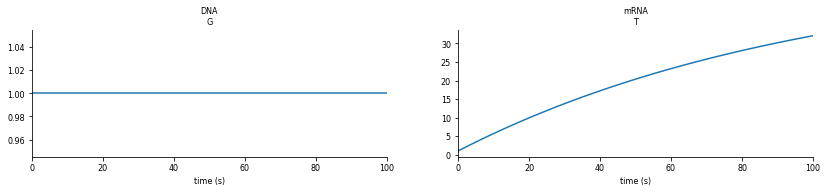

In [29]:
# make the transcription process
config = {
    'stochastic': False
}
transcription_process = Transcription(config)

# simulate with helper function simulate_process_in_experiment
sim_settings = {
    'total_time': 100}
transcription_output = simulate_process_in_experiment(
    transcription_process, 
    sim_settings)

# plot output
plot_settings = {
    'column_width': 7}
fig = plot_simulation_output(
    transcription_output, 
    plot_settings)

# Example: Translation process

* $T \xrightarrow[]{k_{X}} T + X $ 
* $X \xrightarrow[]{d_{X}} \emptyset$


In [4]:
class Translation(Process):

    name = 'translation'
    defaults = {
        'k_X': 0.5,
        'd_X': 0.001}
    
    def __init__(self, parameters=None):
        super(Translation, self).__init__(parameters)
    
    def ports_schema(self):
        return {
            'mRNA': {
                'T': {
                    '_default': 1.0,
                    '_emit': True}},
            'Protein': {
                'X': {
                    '_default': 1.0,
                    '_emit': True}}}
    
    def next_update(self, timestep, states):
        T = states['mRNA']['T']
        X = states['Protein']['X']
        dX = (self.parameters['k_X'] * T - self.parameters['d_X'] * X) * timestep
        return {
            'Protein': {
                'X': dX}}

# Simulate Translation Process on its own


Experiment ID: 5e34a46a-43bf-11eb-b9a3-acde48001122
Created: 12/21/2020 at 11:04:36
Progress:|██████████████████████████████████████████████████| 0.0/100.0 simulated seconds remaining    
Completed in 0.020076 seconds


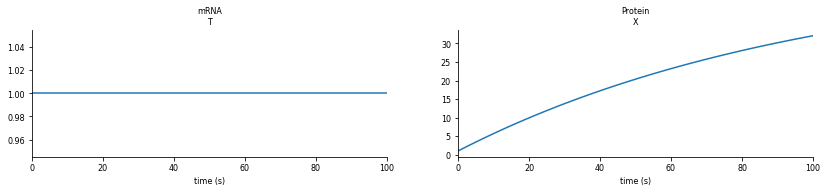

In [5]:
# make the translation process
translation_process = Translation()

# simulate with helper function simulate_process_in_experiment
sim_settings = {
    'total_time': 100}
translation_output = simulate_process_in_experiment(
    translation_process, 
    sim_settings)

# plot output
plot_settings = {
    'column_width': 7}
fig = plot_simulation_output(
    translation_output, 
    plot_settings)

# 2. Make a Composite
**Composites** are bundles of processes linked through their ports by a **topology**. Stores are automatically constructed based on the declared schema of the included processes.

A composite requires the following methods:
1. `generate_processes`: returns a dictionary of the initialized processes.
2. `generate_topology`: returns a dictionary that declares how processes are wired to shared stores. 

# Example: Transcription + Translation composite (TxTl)

In [6]:
class TxTl(Composite):
    name = 'transcription_translation'
    defaults = {
        'Tx': {},
        'Tl': {},
    }

    def __init__(self, config):
        super(TxTl, self).__init__(config)
    
    def generate_processes(self, config):
        return {
            'Tx': Transcription(config['Tx']),
            'Tl': Translation(config['Tl']),
        }

    def generate_topology(self, config):
        return {
            'Tx': {
                'DNA': ('DNA',),
                'mRNA': ('mRNA',),
            },
            'Tl': {
                'mRNA': ('mRNA',),
                'Protein': ('Protein',),
            },
        }

# Simulate TxTl


Experiment ID: 5e5adbee-43bf-11eb-b9a3-acde48001122
Created: 12/21/2020 at 11:04:36
Progress:|██████████████████████████████████████████████████| 0.0/1000.0 simulated seconds remaining    
Completed in 0.197615 seconds


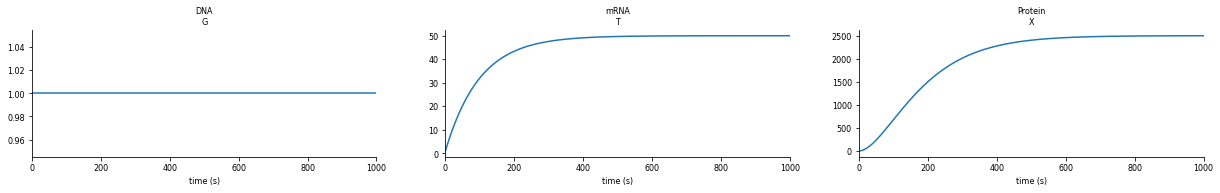

In [7]:
# initialize TxTl composite
tx_tl_params = {}
tx_tl_composite = TxTl(tx_tl_params)

# make the experiment
sim_settings = {}
tx_tl_experiment = compartment_in_experiment(
    tx_tl_composite, 
    sim_settings)

# run for 4000 seconds and retrieve the data
tx_tl_experiment.update(1000)
tx_tl_data = tx_tl_experiment.emitter.get_timeseries()

# plot output
plot_settings = {
    'column_width': 7}
fig = plot_simulation_output(
    tx_tl_data, 
    plot_settings)